In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers, models
import pandas as pd

In [3]:
train_directory = "final_images/train"
train_filtered_directory = "final_images_filtered/train"

img_width = 256
img_height = 256
batch_size = 32

In [4]:
cnn_model = keras.models.load_model("cnn-5-over.h5") # 32, 256, 256, 3
resnet_model = keras.models.load_model("2_appended_conv2D.h5") # 32, 512, 256 ,3

2022-11-26 13:46:53.650432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 13:46:53.661816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 13:46:53.662634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 13:46:53.663838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    label_mode="categorical",
    seed=40,
    image_size=(img_height, img_width),
    batch_size=None,
    shuffle=False)

train_filtered_ds = tf.keras.utils.image_dataset_from_directory(
    train_filtered_directory,
    label_mode="categorical",
    seed=40,
    image_size=(img_height, img_width),
    batch_size=None,
    shuffle=False)

all_train_ds = tf.data.Dataset.zip((train_ds, train_filtered_ds))

process_train_ds = all_train_ds.map(
    lambda img_pair_1, img_pair_2: (tf.concat([img_pair_1[0], img_pair_2[0]], axis=0), img_pair_1[1]))

transformed_train_ds = process_train_ds.batch(batch_size)

train_ds_r = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    label_mode="categorical",
    seed=40,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False)

Found 14002 files belonging to 9 classes.
Found 14002 files belonging to 9 classes.
Found 14002 files belonging to 9 classes.


In [7]:
train_results = pd.DataFrame(columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], dtype=np.float32)

In [9]:
for (img_batch, lbl_batch), (t_img_batch, t_lbl_batch) in zip(train_ds_r, transformed_train_ds):
    a = cnn_model.predict(img_batch)
    b = resnet_model.predict(t_img_batch)
    c = np.expand_dims(np.argmax(lbl_batch, axis=1), axis=1)
    e = np.append(a, b, axis=1)
    e = np.append(e, c, axis=1)
    train_results = train_results.append(pd.DataFrame(e))

2022-11-26 13:47:09.284359: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


1/1 [==============================] - 3s 3s/step


In [ ]:
train_results.to_csv("train_results.csv")

In [3]:
train_results = pd.read_csv("train_results.csv")
train_results.pop("Unnamed: 0")

0         0
1         1
2         2
3         3
4         4
         ..
13997    13
13998    14
13999    15
14000    16
14001    17
Name: Unnamed: 0, Length: 14002, dtype: int64

In [4]:
train_results_features = train_results.copy()
train_results_labels = train_results_features.pop("18")
train_results_features = np.array(train_results_features)

train_results_labels_hot = np.zeros((train_results_labels.size, 9))
train_results_labels = train_results_labels.astype(np.uint8)
train_results_labels_hot[np.arange(train_results_labels.size), train_results_labels] = 1

In [5]:
val_results = pd.read_csv("val_results.csv")
val_results.pop("Unnamed: 0")

0        0
1        1
2        2
3        3
4        4
        ..
1742    14
1743    15
1744    16
1745    17
1746    18
Name: Unnamed: 0, Length: 1747, dtype: int64

In [6]:
val_results_features = val_results.copy()
val_results_labels = val_results_features.pop("18")
val_results_features = np.array(val_results_features)

val_results_labels_hot = np.zeros((val_results_labels.size, 9))
val_results_labels = val_results_labels.astype(np.uint8)
val_results_labels_hot[np.arange(val_results_labels.size), val_results_labels] = 1

### Model

In [7]:
from tensorflow import keras
from keras import layers, models

In [119]:
model = models.Sequential()
model.add(keras.Input(shape=(18)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                1216      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 9)                 585       
                                                                 
Total params: 5,961
Trainable params: 5,961
Non-trainable params: 0
_________________________________________________________________


In [122]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['categorical_accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    'ensemble-nn.h5',
    monitor="val_categorical_accuracy",
    mode="max", verbose=1, save_best_only=True)

In [123]:
history = model.fit(train_results_features, train_results_labels_hot,
    epochs=100,
    validation_data=(val_results_features, val_results_labels_hot),
    batch_size=batch_size,
    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
432/438 [============================>.] - ETA: 0s - loss: 0.2681 - categorical_accuracy: 0.9490
Epoch 1: val_categorical_accuracy improved from -inf to 0.89926, saving model to ensemble-cnn.h5
438/438 [==============================] - 2s 4ms/step - loss: 0.2648 - categorical_accuracy: 0.9497 - val_loss: 0.4230 - val_categorical_accuracy: 0.8993
Epoch 2/100
431/438 [============================>.] - ETA: 0s - loss: 0.0075 - categorical_accuracy: 0.9982
Epoch 2: val_categorical_accuracy improved from 0.89926 to 0.90326, saving model to ensemble-cnn.h5
438/438 [==============================] - 2s 4ms/step - loss: 0.0074 - categorical_accuracy: 0.9982 - val_loss: 0.4703 - val_categorical_accuracy: 0.9033
Epoch 3/100
425/438 [============================>.] - ETA: 0s - loss: 0.0061 - categorical_accuracy: 0.9984
Epoch 3: val_categorical_accuracy did not improve from 0.90326
438/438 [==============================] - 2s 4ms/step - loss: 0.0059 - categorical_accuracy: 0.9984 - 

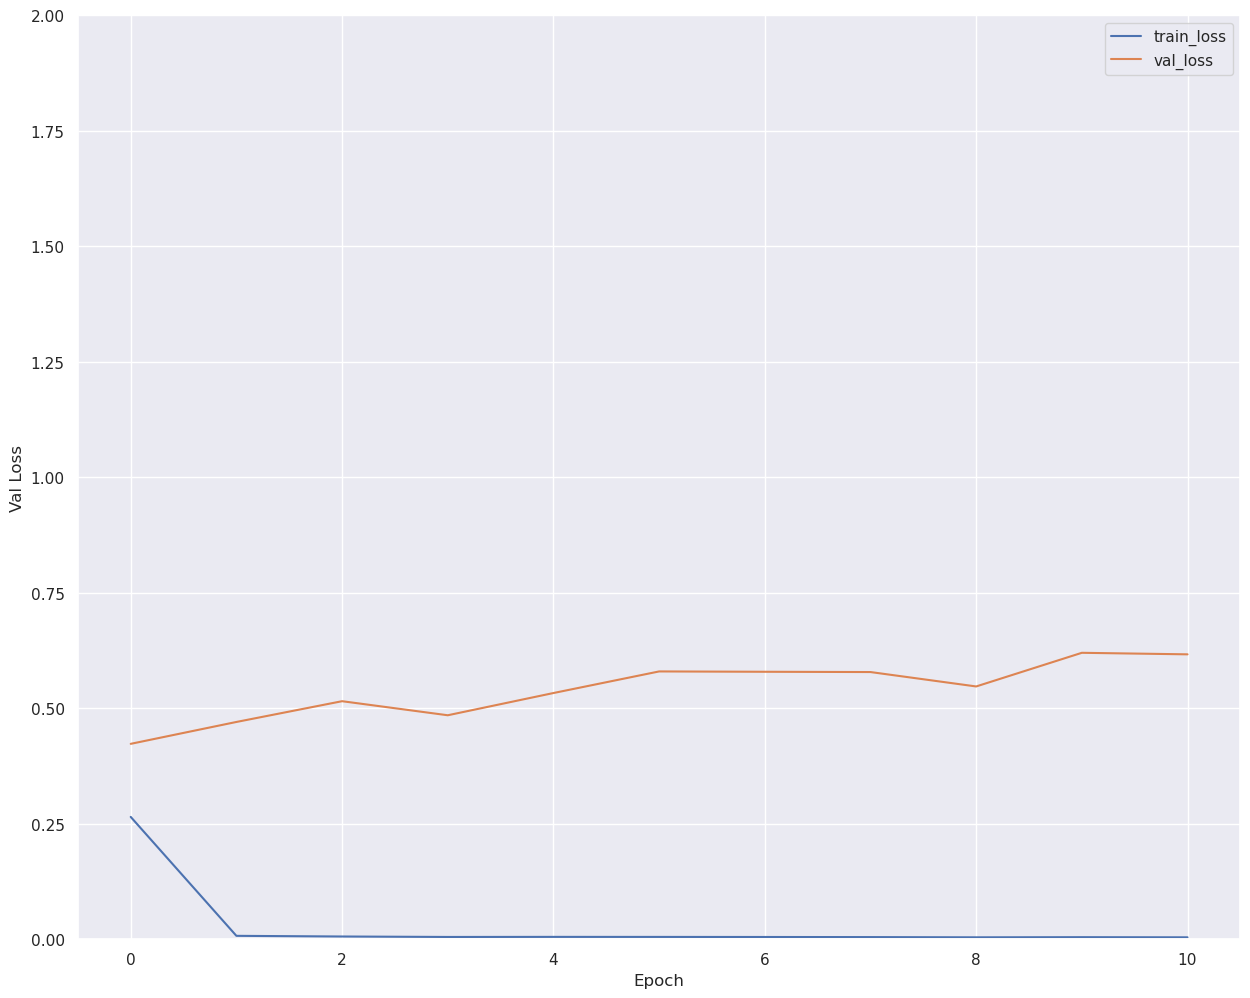

In [190]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Val Loss')
plt.ylim([0, 2])
plt.legend(loc='upper right')

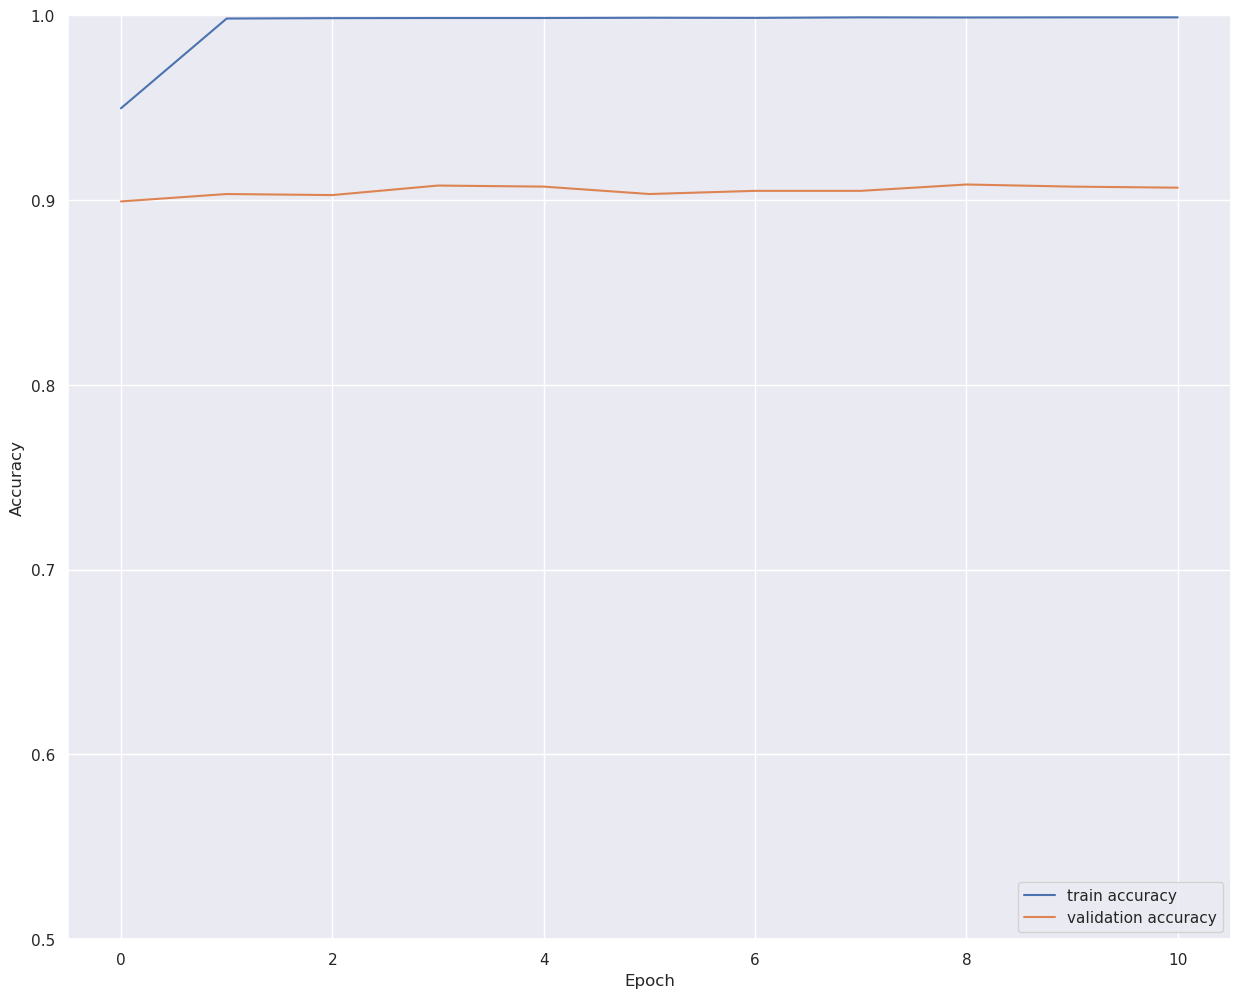

In [191]:
plt.plot(history.history['categorical_accuracy'], label='train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [8]:
test_results = pd.read_csv("test_results.csv")
test_results.pop("Unnamed: 0")

0        0
1        1
2        2
3        3
4        4
        ..
1755    27
1756    28
1757    29
1758    30
1759    31
Name: Unnamed: 0, Length: 1760, dtype: int64

In [9]:
test_results_features = test_results.copy()
test_results_labels = test_results_features.pop("18")
test_results_features = np.array(test_results_features)

test_results_labels_hot = np.zeros((test_results_labels.size, 9))
test_results_labels = test_results_labels.astype(np.uint8)
test_results_labels_hot[np.arange(test_results_labels.size), test_results_labels] = 1

In [10]:
best_model = keras.models.load_model("ensemble-nn.h5")
test_loss, test_acc = best_model.evaluate(test_results_features, test_results_labels_hot, verbose=2)

55/55 - 0s - loss: 0.4966 - categorical_accuracy: 0.9170 - 356ms/epoch - 6ms/step


In [11]:
y_true = []
y_pred = []

for features, labels in zip(test_results_features, test_results_labels_hot):
    y_true.append(np.argmax(labels))
    y_pred.append(np.argmax(best_model.predict(np.expand_dims(features, axis=0))))

1/1 [==============================] - 0s 18ms/step


In [14]:
import seaborn as sns
from sklearn.metrics import f1_score

In [15]:
score = f1_score(y_true, y_pred, average="micro")
print(score)

0.9170454545454545


<AxesSubplot: >

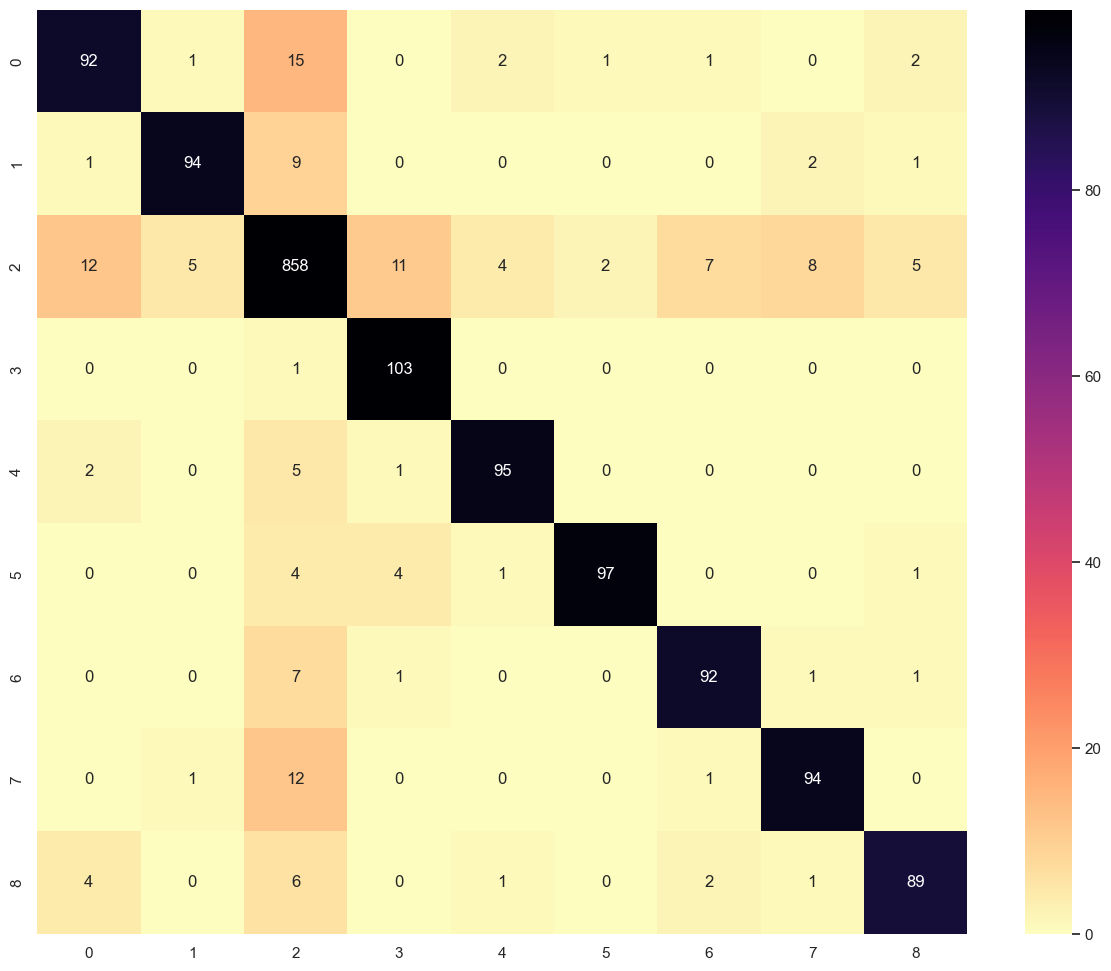

In [16]:
sns.set(rc = {'figure.figsize':(15,12)})
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)
color_map = sns.color_palette("magma_r", as_cmap=True)
sns.heatmap(confusion_matrix, annot=True, cmap=color_map, fmt='d', robust=True)

<AxesSubplot: >

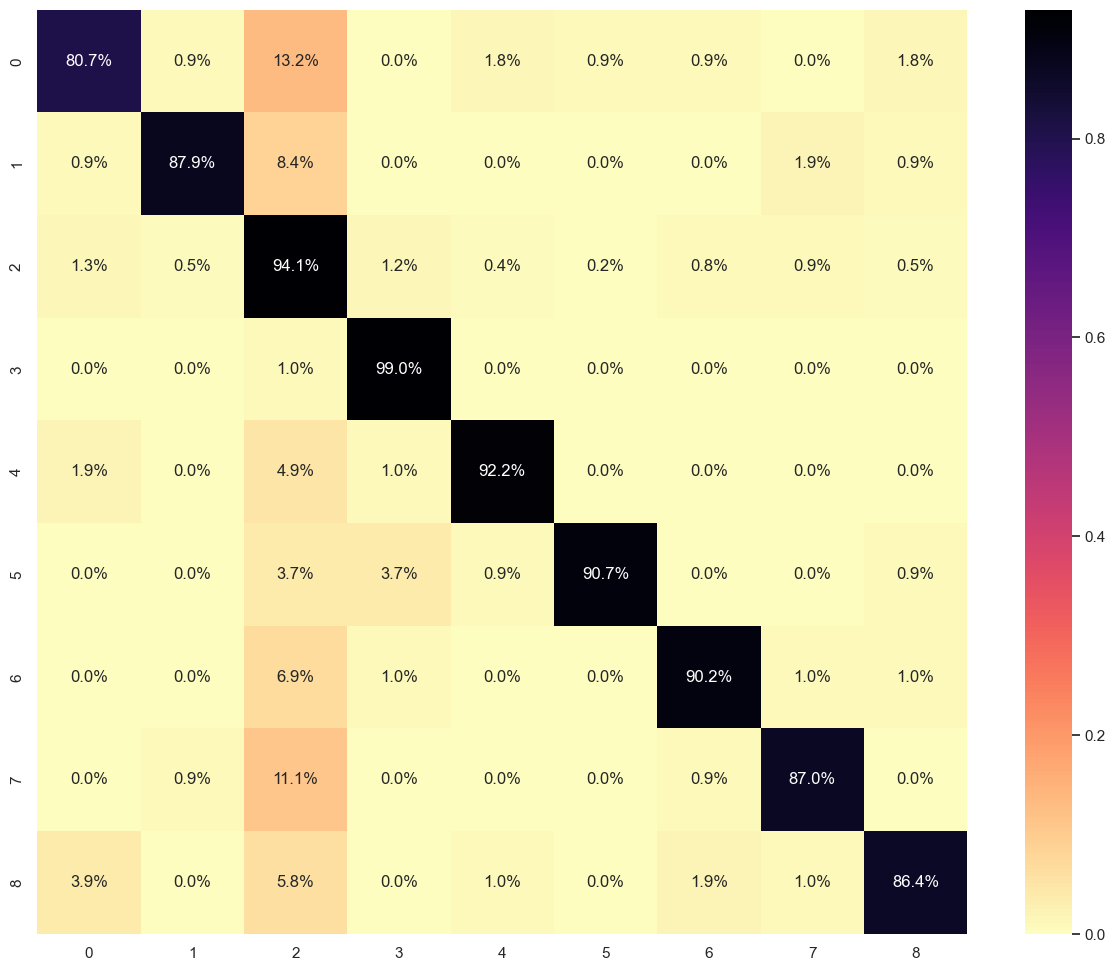

In [17]:
sns.set(rc = {'figure.figsize':(15,12)})
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
confusion_matrix = confusion_matrix.astype(np.float32) / confusion_matrix.sum(axis=1)[:, np.newaxis]
color_map = sns.color_palette("magma_r", as_cmap=True)
sns.heatmap(confusion_matrix, annot=True, cmap=color_map, fmt='.1%', robust=True)

In [12]:
y_true_val = []
y_pred_val = []

for features, labels in zip(val_results_features, val_results_labels_hot):
    y_true_val.append(np.argmax(labels))
    y_pred_val.append(np.argmax(best_model.predict(np.expand_dims(features, axis=0))))

1/1 [==============================] - 0s 22ms/step


In [18]:
score = f1_score(y_true_val, y_pred_val, average="micro")
print(score)

0.9084144247281053


<AxesSubplot: >

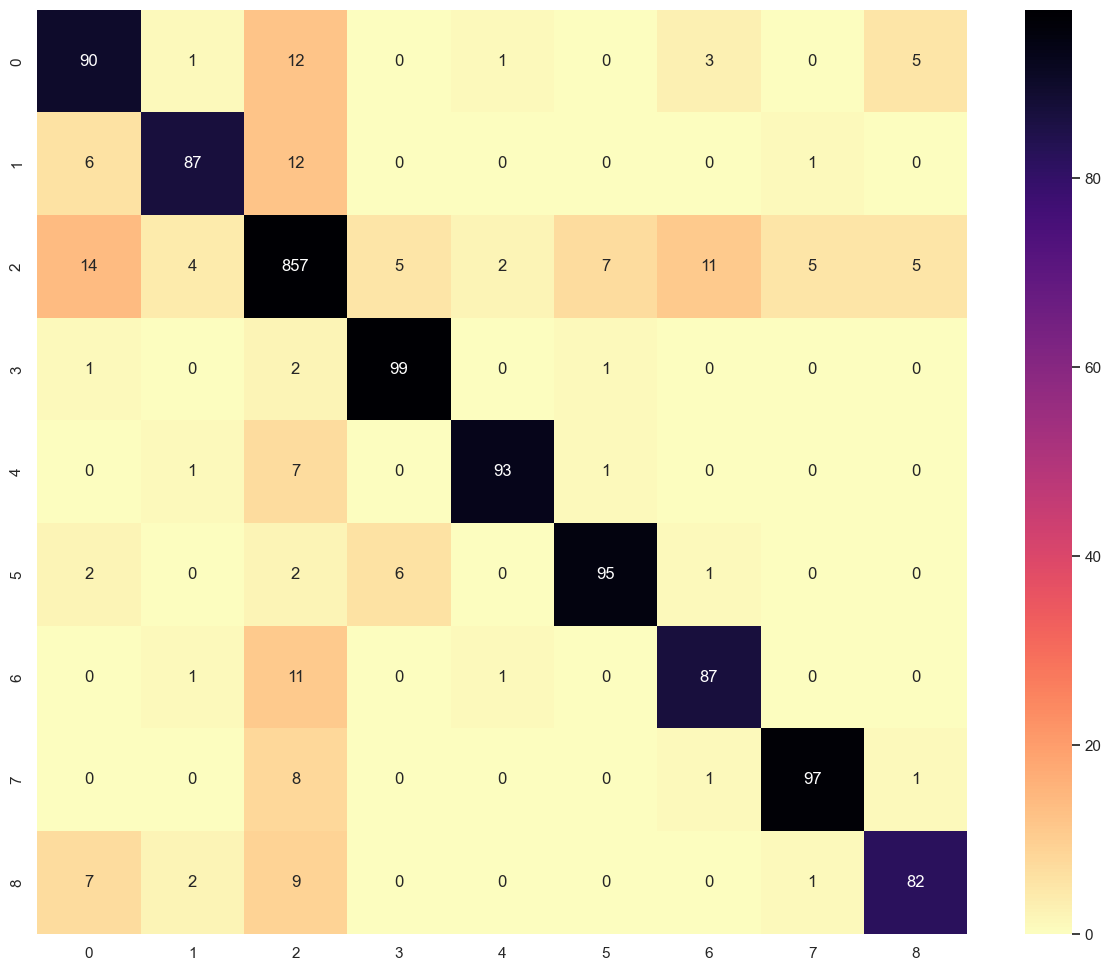

In [19]:
sns.set(rc = {'figure.figsize':(15,12)})
confusion_matrix = tf.math.confusion_matrix(y_true_val, y_pred_val)
color_map = sns.color_palette("magma_r", as_cmap=True)
sns.heatmap(confusion_matrix, annot=True, cmap=color_map, fmt='d', robust=True)

<AxesSubplot: >

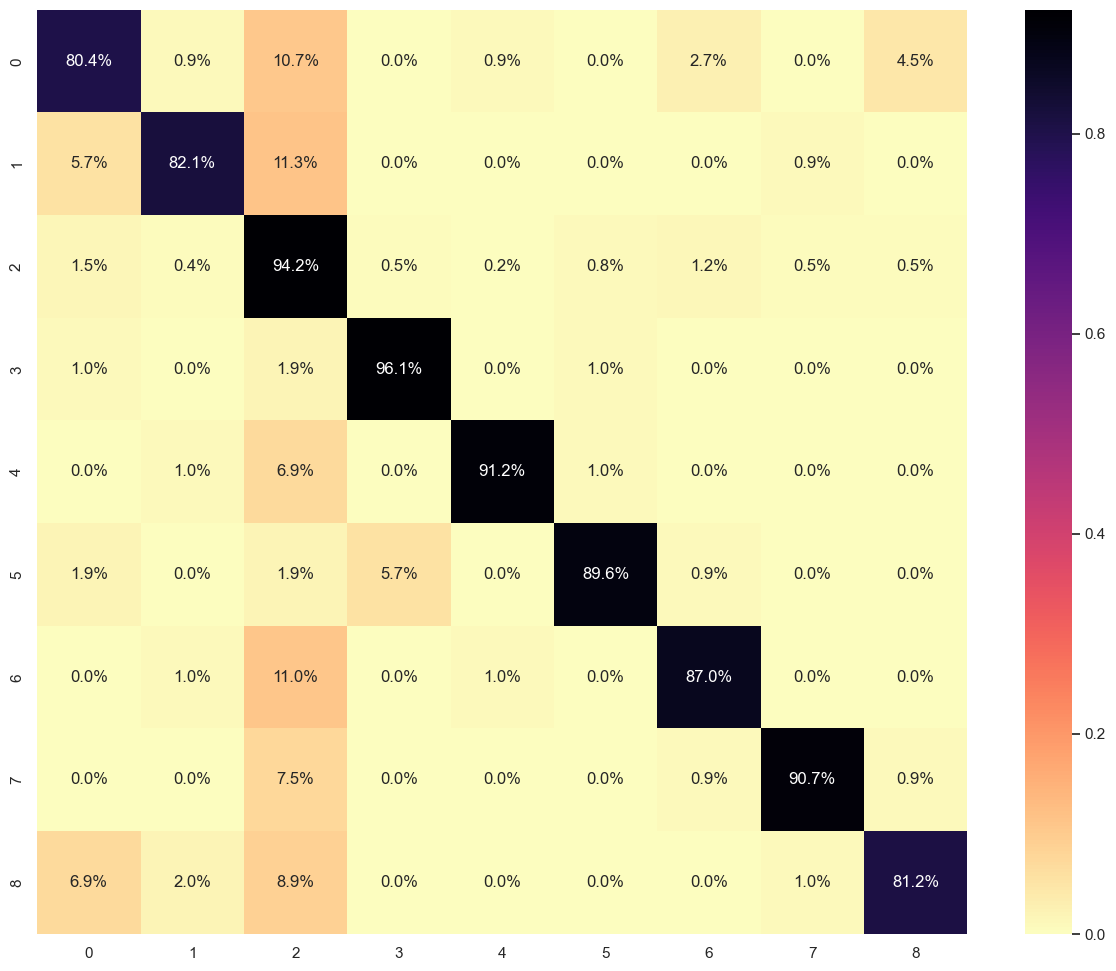

In [20]:
sns.set(rc = {'figure.figsize':(15,12)})
confusion_matrix = tf.math.confusion_matrix(y_true_val, y_pred_val).numpy()
confusion_matrix = confusion_matrix.astype(np.float32) / confusion_matrix.sum(axis=1)[:, np.newaxis]
color_map = sns.color_palette("magma_r", as_cmap=True)
sns.heatmap(confusion_matrix, annot=True, cmap=color_map, fmt='.1%', robust=True)